## snippet collection for basic ml learning

In [1]:
# !GIT_SSL_NO_VERIFY=true git clone https://github.com/shenweichen/DeepMatch
# !pip install --trusted-host=pypi.org --trusted-host=files.pythonhosted.org --user implicit
# !pip install --trusted-host=pypi.org --trusted-host=files.pythonhosted.org --user lightfm

https://github.com/a-milenkin/Competitive_Data_Science - много шаблонов по соревновательному ds
https://pytorch.org/blog/introducing-torchmultimodal/ - torch multimodal
https://drive.google.com/file/d/1zlAbolrErs992uo9NI2CTi-C8r90ZSWh/view - презентация с вебинара подготовки

In [7]:
import  os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import json
import re
import pickle
from copy import copy, deepcopy
from tqdm import tqdm
tqdm.pandas()

In [133]:
df = pd.DataFrame(json.load(open("test_dataset.json", encoding="utf-8")))

## auto fill all nan

In [134]:
def fill_nan_in_df(df, func_int_agregation, cat_value=""):
    df = df.copy()

    for column, dtype in zip(df.columns, df.dtypes):
        if dtype == object:
            new_column = df[column].fillna(cat_value)
        else:
            new_column = df[column].fillna(func_int_agregation(df[column]))

        df[column] = new_column
    return df

In [135]:
df = fill_nan_in_df(df, func_int_agregation=lambda x: x.median(), cat_value="")

In [ ]:
df.drop("text_params", axis=1, inplace=True)

In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1480 entries, 0 to 1479
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   url                          1480 non-null   object 
 1   price                        1480 non-null   object 
 2   old_price                    1480 non-null   object 
 3   order_count                  1480 non-null   float64
 4   celler_sold                  1480 non-null   object 
 5   celler_rating                1480 non-null   float64
 6   name_comp                    1480 non-null   object 
 7   celler_mean_delivery_time    1480 non-null   object 
 8   celler_percent_bad_products  1480 non-null   object 
 9   celler_working_time          1480 non-null   object 
 10  celler_link                  1480 non-null   object 
 11  img_link                     1480 non-null   object 
 12  description                  1480 non-null   object 
 13  text_params       

## пропроцессинг текста

In [139]:
import pymorphy2
from nltk.corpus import stopwords

morph = pymorphy2.MorphAnalyzer(lang='ru')
russian_stopwords = stopwords.words("russian")

# TODO добавить команды для установки языковых пакетов
# TODO попробовать пакеты для английского
# TODO подумать над упаковкой в pypi либу
# morph = pymorphy2.MorphAnalyzer(lang='en')
# russian_stopwords = stopwords.words("english")

MAX_WORDS_COUNT = 10000

def preprocessing_text(text, use_stopwords=True):
    stopwords = copy(russian_stopwords) if use_stopwords else []

    if text is None:
        return " "
    text = str(text)

    if text is None: return None
    text = text.replace("\n", " ")
    text = re.sub('[0-9:,\.!?()-/+*;•$&%]', '', text.lower())
    text = " ".join([morph.parse(word)[0].normal_form for word in text.split()[:MAX_WORDS_COUNT]
                     if word not in stopwords])
    return text

print(preprocessing_text("Привет тест проепроцесснинга текста раз два три"))
#print(preprocessing_text("hello I'am go to Novosibirsk! Good luck!"))

привет тест проепроцесснинг текст


In [140]:
df["description_clear"] = [preprocessing_text(i) for i in tqdm(df.description)]

100%|██████████| 1480/1480 [00:47<00:00, 31.22it/s]


## BERT embeddings

In [17]:
import torch
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny")
# model.cuda()  # uncomment it if you have a GPU

def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

## CLIP embeddings

In [ ]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

In [ ]:
inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True)
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

## VIT embeddings

In [4]:
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])


KeyboardInterrupt



## TFIDF

In [141]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD


def vectorize_column(df, column_name, num_features=None, vectorizer=None, demension_reducer=None):
    df = df.copy()

    if vectorizer is None:
        vectorizer = TfidfVectorizer(max_features=num_features)
        res_emb = vectorizer.fit_transform(df[column_name]).toarray()
    else:
        res_emb = vectorizer.transform(df[column_name]).toarray()


    if demension_reducer is not None:
        res_emb = demension_reducer.fit_transform(res_emb)

    tfidf_inter_df = pd.DataFrame(res_emb, columns=[f"tfidf_{column_name}_{i}" for i in range(res_emb.shape[1])]).set_index(df.index)

    result_dataset =  pd.concat([df, tfidf_inter_df], axis=1)

    return vectorizer, demension_reducer, result_dataset

In [142]:
pca = PCA(n_components=10)

# векторизуем на трейне текстовый столбец (обучаем векторизатор и pca если передан
vectorizer, pca, df_with_tfidf = vectorize_column(df, "description_clear", num_features=40, demension_reducer=pca)

# df.drop("description", axis=1, inplace=True)

# векторизуем на тесте ничего не обучая
_, _, df_with_tfidf = vectorize_column(df, "description_clear", vectorizer=vectorizer, demension_reducer=pca)

In [143]:
df = df_with_tfidf

## визуализируем ембединги

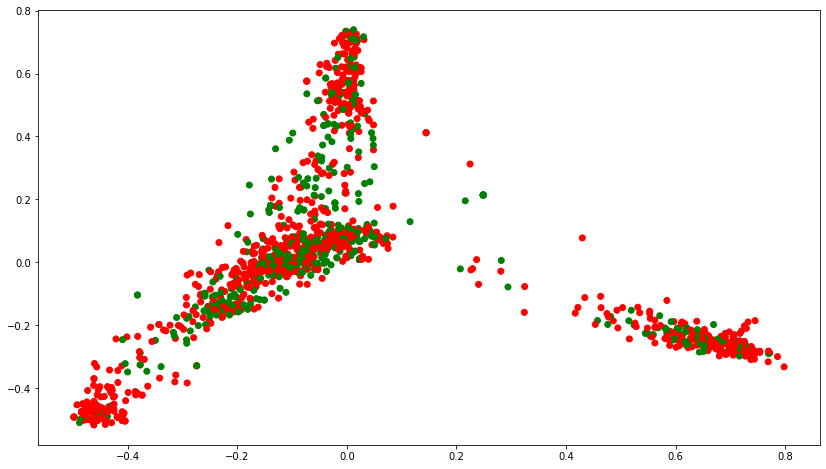

In [144]:
tmp_pca = PCA(n_components=2)
embeds = tmp_pca.fit_transform(vectorizer.transform(df["description_clear"]).toarray())
answers = np.array([i > 4.5 for i in df.celler_rating])

plt.figure(figsize=(14, 8))
colormap = {0: "green", 1: "red"}
plt.scatter(embeds[:, 0], embeds[:, 1], c=[colormap[answer] for answer in answers])

In [145]:
from sklearn.cluster import KMeans

def add_cluster_number_as_feature(df, column_names, clusterer=None, n_cluster=3, feature_name="cluster_number"):
    df = df.copy()

    df_for_clustering = df[column_names]

    if clusterer is None:
        clusterer = KMeans(n_clusters=n_cluster).fit(df_for_clustering)

    num_cluster = clusterer.predict(df_for_clustering)
    df[feature_name] = num_cluster
    return clusterer, df

In [146]:
clusterer, df1 = add_cluster_number_as_feature(df, column_names=['order_count', 'celler_rating', 'tfidf_description_clear_0'],
                              n_cluster=3, feature_name="cluster_by_main")

c:\users\iltya\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [149]:
# добавляем на тест
_, df = add_cluster_number_as_feature(df, column_names=['order_count', 'celler_rating', 'tfidf_description_clear_0'],
                              clusterer=clusterer,  feature_name="cluster_by_main")

In [154]:
df

,url,price,old_price,order_count,celler_sold,celler_rating,name_comp,celler_mean_delivery_time,celler_percent_bad_products,celler_working_time,...,tfidf_description_clear_1,tfidf_description_clear_2,tfidf_description_clear_3,tfidf_description_clear_4,tfidf_description_clear_5,tfidf_description_clear_6,tfidf_description_clear_7,tfidf_description_clear_8,tfidf_description_clear_9,cluster_by_main
0,https://www.wildberries.ru/catalog/171820761/d...,1400,2800,600.0,,4.5,Panda Glamour,,,2 года и 3 мес,...,0.549381,-0.259671,0.094402,0.010375,-0.507594,0.187628,0.039001,0.259129,-0.009872,0
1,https://www.wildberries.ru/catalog/169684868/d...,1530,4500,600.0,,3.9,МИР ОПТОМ,97.2%,,2 года и 2 мес,...,-0.012651,0.063682,-0.094506,-0.015790,-0.019928,0.016813,0.045387,-0.238227,0.576628,0
2,https://www.wildberries.ru/catalog/59353477/de...,839,1199,6400.0,,4.7,ПЛЭЙТУДЭЙ СНГ,,,11 лет,...,-0.328965,-0.327778,0.191505,0.037466,-0.029365,-0.013465,0.021447,-0.061193,0.080800,0
3,https://www.wildberries.ru/catalog/139772047/d...,219,399,400.0,,4.3,Jungle Story,,,2 года и 6 мес,...,-0.274468,-0.075520,0.029552,-0.006851,-0.036041,0.032310,-0.241835,-0.068716,-0.092150,0
4,https://www.wildberries.ru/catalog/160993762/d...,1899,6126,200.0,,4.8,BAROUZ,100%,,3 года и 10 мес,...,-0.039155,0.104619,-0.405869,-0.058898,0.091910,0.349245,0.010440,0.010855,-0.344945,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475,https://www.wildberries.ru/catalog/34169313/de...,,,400.0,,4.7,АГОРА ЭНЕРДЖИ,95.8%,,3 года,...,-0.293816,-0.093399,0.085325,-0.078314,-0.052609,0.032321,-0.402766,-0.021826,-0.068507,0
1476,https://www.wildberries.ru/catalog/171798718/d...,318,707,600.0,,4.5,МОСКВА ФМ,99.1%,,2 года и 9 мес,...,0.619088,-0.311549,0.283885,-0.282343,0.340219,-0.078175,-0.036763,-0.031924,-0.027429,0
1477,https://www.wildberries.ru/catalog/65453462/de...,1041,1554,400.0,,4.7,Baryshnikov,,,3 года и 2 мес,...,0.028669,0.565696,0.207673,0.124776,-0.095649,0.022058,0.008017,-0.088639,-0.213006,0
1478,https://www.wildberries.ru/catalog/169291884/d...,3162,6200,600.0,,3.9,CITYLINK,100%,,3 мес,...,0.066660,0.088676,-0.202100,0.214619,0.016178,-0.015319,0.102662,-0.229175,-0.255672,0


## Catboost

In [161]:
text_features = ["description_clear", "description", ]

In [162]:
cat_names = []
TARGET_FEATURE = "celler_rating"

for column_name, dtype in zip(df.columns, df.dtypes):
    if dtype == object and column_name != TARGET_FEATURE and column_name not in text_features:
        cat_names.append(column_name)

In [163]:
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from sklearn.model_selection import train_test_split

y = df[TARGET_FEATURE]
X = df.drop(TARGET_FEATURE, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [164]:
train_data = Pool(data=X_train, label=y_train, cat_features=cat_names, text_features=text_features)
test_data = Pool(data=X_test, label=y_test, cat_features=cat_names, text_features=text_features)

## Regression

In [167]:
reg = CatBoostRegressor(n_estimators=100, eval_metric="MAE")

reg.fit(train_data, eval_set=test_data, early_stopping_rounds=100,)

Learning rate set to 0.213016
0:	learn: 0.2560384	test: 0.2277475	best: 0.2277475 (0)	total: 262ms	remaining: 26s
1:	learn: 0.2492897	test: 0.2223667	best: 0.2223667 (1)	total: 571ms	remaining: 28s
2:	learn: 0.2448950	test: 0.2211352	best: 0.2211352 (2)	total: 808ms	remaining: 26.1s
3:	learn: 0.2420447	test: 0.2197129	best: 0.2197129 (3)	total: 1.03s	remaining: 24.8s
4:	learn: 0.2395421	test: 0.2174919	best: 0.2174919 (4)	total: 1.26s	remaining: 24s
5:	learn: 0.2361754	test: 0.2158319	best: 0.2158319 (5)	total: 1.54s	remaining: 24.2s
6:	learn: 0.2351580	test: 0.2153412	best: 0.2153412 (6)	total: 1.76s	remaining: 23.4s
7:	learn: 0.2327327	test: 0.2142753	best: 0.2142753 (7)	total: 1.99s	remaining: 22.9s
8:	learn: 0.2314888	test: 0.2135767	best: 0.2135767 (8)	total: 2.2s	remaining: 22.3s
9:	learn: 0.2310891	test: 0.2127215	best: 0.2127215 (9)	total: 2.41s	remaining: 21.7s
10:	learn: 0.2287082	test: 0.2123093	best: 0.2123093 (10)	total: 2.64s	remaining: 21.4s
11:	learn: 0.2276164	test: 0.

In [169]:
reg.get_feature_importance(prettified=True)

,Feature Id,Importances
0,description_clear,46.273903
1,description,18.263588
2,search_category,15.633687
3,tfidf_description_clear_0,3.284431
4,name_comp,3.280938
5,celler_working_time,2.740515
6,tfidf_description_clear_9,2.364341
7,celler_mean_delivery_time,1.952822
8,tfidf_description_clear_7,1.424313
9,tfidf_description_clear_1,1.267232


In [174]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

print("model error: ", mean_absolute_percentage_error(y_test, reg.predict(X_test)))
print("mean value error: ", mean_absolute_percentage_error(y_test, [y_test.mean()] * len(y_test)))

model error:  0.04729634733168501
mean value error:  0.052133780774110176


## Classification
TODO